In [1]:
import tensorflow as tf
from tensorflow.keras import Input, layers
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from datetime import datetime
from sklearn.model_selection import train_test_split as tvsplit
# disable logging warning and error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.config.run_functions_eagerly(True)
# tf.config.experimental_run_functions_eagerly(True) tensorflow <= 2.2

In [2]:
sample_n = 100
epochs = 50

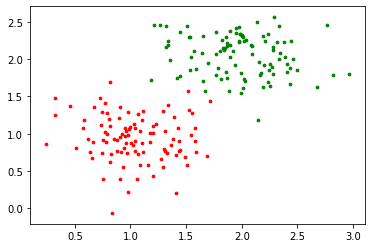

In [3]:
meana = np.array([1, 1])
cova = np.array([[0.1, 0],[0, 0.1]])

meanb = np.array([2, 2])
covb = np.array([[0.1, 0],[0, 0.1]])

x_red = np.random.multivariate_normal(mean=meana, cov = cova, size=sample_n)
x_green = np.random.multivariate_normal(mean=meanb, cov = covb, size=sample_n)

y_red = np.array([1] * sample_n)
y_green = np.array([0] * sample_n)

plt.scatter(x_red[:, 0], x_red[:, 1], c = 'red' , marker='.', s = 30)
plt.scatter(x_green[:, 0], x_green[:, 1], c = 'green', marker='.', s = 30)
# plt.show()

X = np.concatenate([x_red, x_green]).astype(np.float32)
y = np.concatenate([y_red, y_green]).astype(np.float32)

In [4]:
X_train, X_test, y_train, y_test = tvsplit(X, y)

In [5]:
class Logistic(tf.keras.models.Model):
    def __init__(self, input_size=2, hidden_size = 5, output_size=1, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.inputs_ = tf.keras.Input(shape=(input_size,), dtype=tf.float32, name = "Inputs")
        self._set_input_layer(self.inputs_)
        self.dense = layers.Dense(hidden_size, name = "linear")
        self.outlayer = layers.Dense(output_size, 
                        activation = 'sigmoid', name = "out_layer")
        # self.inputs = tf.nest.map_structure()
        
        self.build()

    def _set_input_layer(self, inputs):
        """add inputLayer to model and display InputLayers in model.summary()

        Args:
            inputs ([dict]): the result from `tf.keras.Input`
        """
        if isinstance(inputs, dict):
            self.inputs_layer = {n: tf.keras.layers.InputLayer(input_tensor=i, name=n) 
                                    for n, i in inputs.items()}
        elif isinstance(inputs, (list, tuple)):
            self.inputs_layer = [tf.keras.layers.InputLayer(input_tensor=i, name=i.name) 
                                    for i in inputs]
        elif tf.is_tensor(inputs):
            self.inputs_layer = tf.keras.layers.InputLayer(input_tensor=inputs, name=inputs.name)
    
    def build(self):
        super(Logistic, self).build(self.inputs_.shape if tf.is_tensor(self.inputs_) else self.inputs_)
        # super(Logistic, self).build((None, 2))
        _ = self.call(self.inputs_)
    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def call(self, X):
        X = self.dense(X)
        Y = self.outlayer(X)
        return Y

In [6]:
model = Logistic()
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])
model.summary()

Model: "logistic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
linear (Dense)               (None, 5)                 15        
_________________________________________________________________
out_layer (Dense)            (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# tensorboard
# logdir = "logs" + os.path.sep + "standard" + os.path.sep + datetime.now().strftime("""%Y%m%d-%H%M%S""")
# callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
# ]

In [10]:
epochs = 200
model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/200
5/5 [==============================] - 0s 50ms/step - loss: 0.8427 - accuracy: 0.4716 - val_loss: 0.7132 - val_accuracy: 0.5800
Epoch 2/200
5/5 [==============================] - 0s 20ms/step - loss: 0.8082 - accuracy: 0.4833 - val_loss: 0.7000 - val_accuracy: 0.5800
Epoch 3/200
5/5 [==============================] - 0s 19ms/step - loss: 0.8034 - accuracy: 0.4781 - val_loss: 0.6876 - val_accuracy: 0.5800
Epoch 4/200
5/5 [==============================] - 0s 19ms/step - loss: 0.7681 - accuracy: 0.4946 - val_loss: 0.6759 - val_accuracy: 0.5800
Epoch 5/200
5/5 [==============================] - 0s 18ms/step - loss: 0.7849 - accuracy: 0.4685 - val_loss: 0.6649 - val_accuracy: 0.5800
Epoch 6/200
5/5 [==============================] - 0s 103ms/step - loss: 0.7585 - accuracy: 0.4833 - val_loss: 0.6548 - val_accuracy: 0.5800
Epoch 7/200
5/5 [==============================] - 0s 22ms/step - loss: 0.7623 - accuracy: 0.4659 - val_loss: 0.6454 - val_accuracy: 0.5800
Epoch 8/200
5/5 [==

In [19]:
loss = model.compiled_loss._loss_metric
loss.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.2209271>

In [22]:
model.trainable = True
loss = model.compiled_loss._loss_metric
# weights = [w for w in model.trainable_weights if 'dense' in w.name and 'bias' in w.name]
opt = model.optimizer
opt.get_gradients(loss.result(), model.trainable_weights)

ValueError: Variable <tf.Variable 'linear/kernel:0' shape=(2, 5) dtype=float32> has `None` for gradient. Please make sure that all of your ops have a gradient defined (i.e. are differentiable). Common ops without gradient: K.argmax, K.round, K.eval.